## Introduction

<b>Source</b>
- https://www.kaggle.com/c/quora-question-pairs
- Applied AI Course


<b>Problem Statement</b>
- Identify which questions asked on Quora are duplicates of questions that have already been asked. 
- This could be useful to instantly provide answers to questions that have already been answered. 
- We are tasked with predicting whether a pair of questions are duplicates or not. 

<b>Business Objectives</b>
- The cost of a mis-classification can be very high. (FP are more critical than FN)
- You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
- No strict latency concerns.
- Interpretability is partially important.

<b>Columns Description</b>
- id: normal index column of data
- qid1: ID for question 1
- qid2: ID for question 2
- question1: Actual text of question 1
- question2: Actual text of question 2
- is_duplicate: Label of whether two questions are duplicate or not. (0 = No, 1 = Yes)

## Imported Libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

## Loading Data

In [5]:
data = pd.read_csv('data/train.csv')
data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [7]:
print('Number of data points are : {}'.format(data.shape[0]))

Number of data points are : 404290


1. qid1 is ID for question 1
2. qid2 is ID for question 2
3. question1 and question2 columns are actual text
4. is_duplicatle is the label, whether the questions are duplicate or not (0 = not duplicate, 1 = duplicate)

## Exploratory Data Analysis

### General

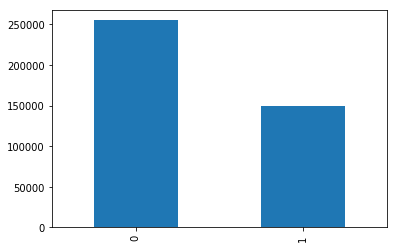

In [9]:
pd.value_counts(data['is_duplicate']).plot.bar()

In [10]:
data['is_duplicate'].value_counts(normalize=True)

0    0.630802
1    0.369198
Name: is_duplicate, dtype: float64

In [11]:
data['is_duplicate'].value_counts()

0    255027
1    149263
Name: is_duplicate, dtype: int64

Out of 404290 question pairs, 255027 Qpairs(\~63%) are not duplicate and 149263 Qpairs(~37%) are duplicate. <b> Slight imbalance in data </b>

In [7]:
allQIDs = pd.Series(data['qid1'].tolist() + data['qid2'].tolist())
num_unique_ques = len(np.unique(allQIDs))
print('Number of unique questions: {}'.format(num_unique_ques))

Number of unique questions: 537933


In [17]:
num_ques_repeat = np.sum(allQIDs.value_counts() > 1)
num_ques_once = np.sum(allQIDs.value_counts() == 1)

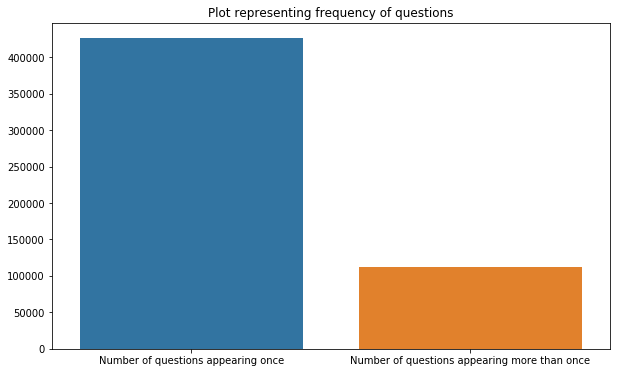

In [19]:
x = ["Number of questions appearing once" , "Number of questions appearing more than once"]
y =  [num_ques_once , num_ques_repeat]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing frequency of questions")
sns.barplot(x,y)
plt.show()

In [20]:
print('Number of questions appearing once: {}'.format(num_ques_once))
print('Number of questions appearing more than once: {}'.format(num_ques_repeat))

Number of questions appearing once: 426153
Number of questions appearing more than once: 111780


1. We have a total of 537933 different question IDs
2. Out of this, 426153 QIDs only appear once.
3. Remaining 111780 QIDs appear more than once.

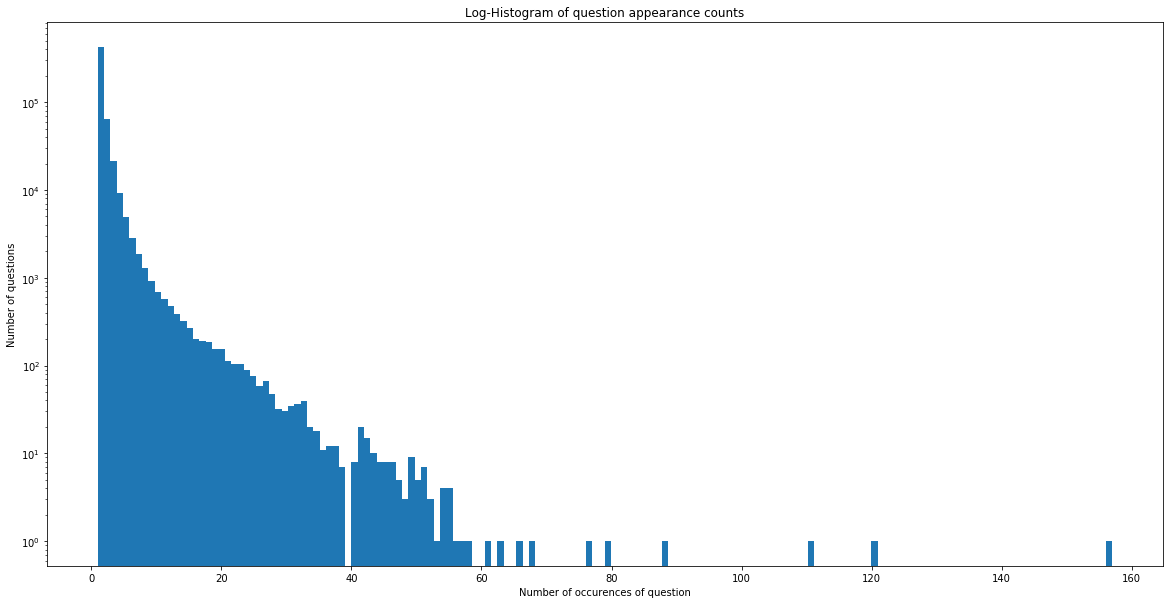

In [28]:
plt.figure(figsize=(20, 10))
plt.hist(allQIDs.value_counts(), bins=160)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')
plt.show()

In [36]:
print('Maximum number of times a single question is repeated: {}'.format(max(allQIDs.value_counts()))) 
print('QID appearing most number of times: {}'.format(allQIDs.value_counts().idxmax()))

Maximum number of times a single question is repeated: 157
QID appearing most number of times: 2559


1. Above histogram also shows us that most questions appear only once
2. One question appear 157 times with QID 2559

In [45]:
data[data['qid1'] == 2559]['question1'].iloc[:1]

14712    What are the best ways to lose weight?
Name: question1, dtype: object

The question that appears most in data is <b> What are the best ways to lose weight?</b>

### Missing Values / NULL Values Check

In [47]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


<b>We have some missing values.</b> <br>
question1 has NULL for one row and question2 for two rows.

In [49]:
nan_rows = data[data.isnull().any(1)]
print (nan_rows)

            id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0  


NaN values appear for QIDs 174364 and 493340. Let's find if we have question for these IDs in our data.

In [54]:
print(data[data['qid1'] == 174364]['question1'])
print(data[data['qid2'] == 174364]['question2'])

print(data[data['qid1'] == 493340]['question1'])
print(data[data['qid2'] == 493340]['question2'])

Series([], Name: question1, dtype: object)
105780    NaN
201841    NaN
Name: question2, dtype: object
363362    NaN
Name: question1, dtype: object
Series([], Name: question2, dtype: object)


As we cannot find any questions for these IDs, it's better to drop these rows.

In [59]:
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 404287 entries, 0 to 404289
Data columns (total 6 columns):
id              404287 non-null int64
qid1            404287 non-null int64
qid2            404287 non-null int64
question1       404287 non-null object
question2       404287 non-null object
is_duplicate    404287 non-null int64
dtypes: int64(4), object(2)
memory usage: 21.6+ MB


<b>We've dropped the rows with NaN values and now our data is free of NULL values</b>

### Checking for Duplicates

In [60]:
np.where(data['qid1'] == data['qid2'])

(array([], dtype=int64),)

Good! We don't have any row where qid1 and qid2 are same

In [61]:
data.drop_duplicates(subset={"qid1","qid2"}, keep='first', inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 404287 entries, 0 to 404289
Data columns (total 6 columns):
id              404287 non-null int64
qid1            404287 non-null int64
qid2            404287 non-null int64
question1       404287 non-null object
question2       404287 non-null object
is_duplicate    404287 non-null int64
dtypes: int64(4), object(2)
memory usage: 21.6+ MB


<b> No duplicates found where two rows have same &lt;qid1, qid2&gt; pair </b>